# Segmentation into ERP epochs

## Import MNE and raw data

~~~python
import mne
mne.set_log_level('error')  # reduce extraneous MNE output
import matplotlib.pyplot as plt
import numpy as np

# Participant ID code
p_id = 'N400_dataset_14'
data_dir = 'data'

raw = mne.io.read_raw_brainvision( 'data/' + p_id + '.vhdr', preload=True)
~~~

In [1]:
import mne
mne.set_log_level("error")
import matplotlib.pyplot as plt
import numpy as np

p_id = "sub-001"
data_dir = "data/" + p_id + "/"

raw_filt = mne.io.read_raw_fif(data_dir + p_id + "-filt-raw.fif")
raw_filt.set_montage("easycap-M1")

Measurement date,"January 20, 2015 13:15:58 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,19 points
Good channels,16 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,500.00 Hz
Highpass,0.10 Hz
Lowpass,30.00 Hz


### MNE's events structure

**Event codes** indicate when events of experimental interest occurred during the EEG recording. They are typically generated by the stimulus computer, and sent to the EEG recording computer at the same time that the stimuli are presented to the participant. Event codes may also mark when a participant made a response (such as a button press, or the onset of a vocal response), or other information such as the start of a new block of trials or condition, rather than a specific stimulus. 

<div class="alert alert-block alert-info">

Event codes can also be generated by devices that detect when a stimulus occurs. For example, a light-sensitive *photodiode* can be used to detect when the brightness of a location on a computer screen changes. This setup can be useful in some situations, because sometimes there is an unpredictable delay between the time that the computer software initiates presentation of a stimulus, and when the hardware actually presents the stimulus. These delays are typically only on the order of a few, or possibly tens, of milliseconds, but that is enough to cause problems when averaging ERPs from multiple trials together — especially if the delay is inconsistent across trials. The result will be that the peaks and troughs of the waveforms do not align perfectly across trials, and the resulting averaged ERP will look more smoothed and less "peaky". Event codes can also be generated by devices that detect when a stimulus occurs. 
</div>

Segmenting the data into ERPs depends on these event codes, since they are what we time-lock to. To use them for ERP segmentation, we need to first extract the timing and identity of each code from the raw data, and store it in a NumPy array. Because event codes are numeric (for reasons explained below), we also need to define a mapping between these numbers and meaningful labels (such as what type of stimulus or experimental condition the code denotes). 

~~~python
events, event_dict = mne.events_from_annotations(raw)
~~~

In [11]:
events, events_dict = mne.events_from_annotations(raw_filt)

We can view the first 10 rows of the events array:
~~~python
events[:10]
~~~

In [12]:
events[:10]

array([[    0,     0,     2],
       [    0,     0,     1],
       [25550,     0,     7],
       [25553,     0,     3],
       [26099,     0,    13],
       [26144,     0,     4],
       [29582,     0,     5],
       [33283,     0,     3],
       [33781,     0,    15],
       [34932,     0,     5]])

`events` is a NumPy array with 3 columns, and one row for each event code in the data. 

The **first column** contains the index of the event code in terms of the data array. Recall that the data were sampled at a rate of 500 Hz, meaning we have one sample (i.e., measurement) every 2 ms. So the values in the first column of `events` are not time measured in milliseconds, but "time" in terms of samples or data points. This is important to remember later, although MNE generally makes it easy to go between samples and more intuitive measures of time like milliseconds or seconds.

The **second column** is usually zero, but is intended to mark the end time of an event, if the event code was send to the EEG system for a period of time. In practice it is rarely used.

The **third column** is the event code itself, as an integer. We'll elaborate later on what each code means.


<div class="alert alert-block alert-info">

Most EEG systems receive event codes from the stimulus computer using an electronic communications protocol called **TTL**, or transistor-to-transistor logic. It's very simple and low-level, and is done via the parallel port of a computer (which is so low-level, computers almost never have these built in anymore). The reason this arcane system is still routinely used in EEG is that its timing is very precise, which means it is the best option to get millisecond-level synchronization between when the stimulus computer presents a stimulus, and when the event code is received by the EEG system. This level of precision is vital in EEG research because the effects of interest occur on a millisecond time scale. The impact of this system for us is that the event codes stored in an EEG data file are usually restricted to integers in the range of 1–255, because that is the (8 bit) resolution of the TTL protocol (i.e., this kind of connection can inherently only send this range of values). Some EEG recording software allows the experimenter to specify text labels for each numerical event code, based on what the numbers mean in that particular experiment. However, in most cases mapping between the numerical event codes and meaningful labels is something we do in preprocessing, as shown below.

</div>

The second output, `event_dict`, is a dictionary mapping labels to the integer codes in the `events` array. The labels were created by the EEG recording software and stored in the raw file, but as you can see below they are mostly not very informative. We can see, however, that the first two codes in the `events` array above simply mark the start of the recording (*actiCAP* is the name of this EEG manufacturer's electrode system).

~~~python
event_dict
~~~

In [13]:
events_dict

{'Comment/actiCAP Data On': 1,
 'New Segment/': 2,
 'Stimulus/S  1': 3,
 'Stimulus/S  2': 4,
 'Stimulus/S  3': 5,
 'Stimulus/S  4': 6,
 'Stimulus/S  5': 7,
 'Stimulus/S  7': 8,
 'Stimulus/S101': 9,
 'Stimulus/S102': 10,
 'Stimulus/S111': 11,
 'Stimulus/S112': 12,
 'Stimulus/S201': 13,
 'Stimulus/S202': 14,
 'Stimulus/S211': 15,
 'Stimulus/S212': 16}

In [14]:
raw = mne.io.read_raw_brainvision(data_dir + p_id + '.vhdr', preload=False)
raw_filt

events_raw, events_dict_raw = mne.events_from_annotations(raw)
events_dict_raw

{'Comment/actiCAP Data On': 10001,
 'New Segment/': 99999,
 'Stimulus/S  1': 1,
 'Stimulus/S  2': 2,
 'Stimulus/S  3': 3,
 'Stimulus/S  4': 4,
 'Stimulus/S  5': 5,
 'Stimulus/S  7': 7,
 'Stimulus/S101': 101,
 'Stimulus/S102': 102,
 'Stimulus/S111': 111,
 'Stimulus/S112': 112,
 'Stimulus/S201': 201,
 'Stimulus/S202': 202,
 'Stimulus/S211': 211,
 'Stimulus/S212': 212}

We will need to create our own dictionary of mappings between the integer event codes and meaningful names based on the design of our experiment. 

### Experimental design

This data set was collected while the participant viewed a series of pictures of objects on a computer screen. One second after each picture was presented, a spoken word was played over a speaker. The word was either the name of the pictured object, or some other word. Based on prior research, we predicted an **N400** ERP component for the mismatch trials relative to those on which the picture and word matched.

The N400 is a component first discovered by [Kutas & Hillyard (1980)](https://dx.doi.org/10.1126/science.7350657), in response to sentences that ended in a word whose meaning was not predicted given the preceding words in the sentence. For example, the sentence *I take my coffee with milk and dog.* would elicit an N400 at the word *dog*. More than 40 years of subsequent research has shown that the N400 is a marker of brain processes involved in integrating new information into an ongoing context that people maintain of words and concepts — or in technical terms, *semantic integration*. Violations of expectations related to the meaning of stimuli evoke an N400 response. In the present experiment, we did not use sentences, however each picture created a context and the subsequent word either fit (matched) or did not fit (mismatched) that context. 

Although there were really only two experimental conditions in this experiment (match and mismatch), as you see there are a lot more than two event codes in the `events` array and `events_dict` dictionary above! This is because in this study, the experimenters coded details of the stimuli in great detail. This is common in research, where we have one central research question, but perhaps other questions relating to more fine-grained details of the stimuli. As well, the stimuli may vary in ways that are not of experimental interest, but are properties that we would like to control for. For now we will label each event code.

### Label Event Codes

We can define a dictionary that maps labels onto each event code of interest. As you can see below, there are 4 event codes associated with Match trials, and 4 associated with Mismatch trials. Later we will merge them before examining the ERPs, but for now we will label each one separately. This preserves the more detailed information, in case later we decide we want to break the data down in a more fine-grained fashion.

~~~python
event_mapping = {'PicOnset':1, 'RespPrompt':2, 'CorResp':3, 'IncorResp':4, 'RespFeedback':5,             
                 'Match/A':111, 'Match/B':211, 'Match/C':112, 'Match/D':212,
                 'Mismatch/A':101, 'Mismatch/B':201, 'Mismatch/C':102, 'Mismatch/D':202
                }
~~~

In [15]:
event_mapping = {'PicOnset':1, 'RespPrompt':2, 'CorResp':3, 'IncorResp':4, 'RespFeedback':5, 'unused':7,          
                 'Match/A':111, 'Match/B':211, 'Match/C':112, 'Match/D':212,
                 'Mismatch/A':101, 'Mismatch/B':201, 'Mismatch/C':102, 'Mismatch/D':202
                }

In [16]:
event_mapping = {v:k for k, v in event_mapping.items()}
event_mapping

{1: 'PicOnset',
 2: 'RespPrompt',
 3: 'CorResp',
 4: 'IncorResp',
 5: 'RespFeedback',
 7: 'unused',
 111: 'Match/A',
 211: 'Match/B',
 112: 'Match/C',
 212: 'Match/D',
 101: 'Mismatch/A',
 201: 'Mismatch/B',
 102: 'Mismatch/C',
 202: 'Mismatch/D'}

In [17]:
event_id = {}

for key, value in events_dict.items():
  
    if 'Stimulus/S' in key:
        orig_event_code = int(key.split('/S')[1])
        event_id[event_mapping[orig_event_code]] = value
        
event_id 

{'PicOnset': 3,
 'RespPrompt': 4,
 'CorResp': 5,
 'IncorResp': 6,
 'RespFeedback': 7,
 'unused': 8,
 'Mismatch/A': 9,
 'Mismatch/C': 10,
 'Match/A': 11,
 'Match/C': 12,
 'Mismatch/B': 13,
 'Mismatch/D': 14,
 'Match/B': 15,
 'Match/D': 16}

MNE's `viz.plot_events()` function will read an events array and plot the timing of event codes over the time, with different rows and colours for each event type. We have to pass the sampling rate (`raw.info['sfreq']`) as the second argument so that MNE knows how to convert the samples in the `events` array to units of time. We also pass `event_mapping` so that the plot has a meaningful legend.



This plot can be very useful to understand the timeline of an experiment, and also to confirm that the types and timing of event codes control what was expected based on the design of the experiment. In the present experiment, all three sentence types were randomly intermixed, so the plot below is consistent with this. 

Note that it's not necessary to use `plt.subplots()` before running any MNE plot routine. However, in some cases, such as this one, MNE's default plot size is not optimal for what is being plotted, so `plt.subplots()` allows us to specify the figure size. Note that when we run the MNE plot command, we don't apply a Matplotlib axis method, but instead pass the `ax` pointer to the subplot to MNE's plot command using the `axes=` kwarg. Many of MNE's plotting commands support this kwarg, but not all (since some MNE plots actually create figures with multiple subplots).

~~~python
fig, ax = plt.subplots(figsize=[15, 5])

mne.viz.plot_events(events, raw.info['sfreq'],  
                    event_id=event_mapping,                    
                    axes=ax)
plt.show()
~~~


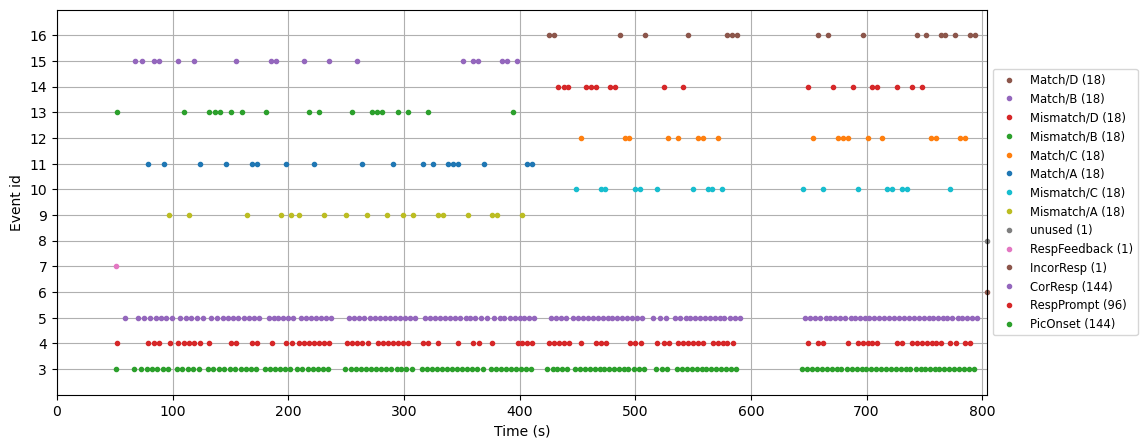

In [18]:
fig, ax = plt.subplots(figsize=[15, 5])

mne.viz.plot_events(events, raw_filt.info["sfreq"],
                    event_id=event_id,
                    axes=ax)
plt.show()

### Segment the data into epochs

Finally, we split the continuous, filtered raw EEG data into epochs time-locked to the event codes of interest, as defined in `event_mapping`. To do this we use `mne.Epochs()`, which creates an object of the class `Epochs`. A number of arguments are necessary; the first 5 of these are *positional* arguments, meaning that the first 5 argument positions must have specific contents:
- the first is the raw data. We pass the filtered data.
- the next two arguments are the events array, and the mapping of events to labels
- the fourth and fifth arguments are the start and end times of each epoch (`timn` and `tmax`), relative to the event code. Typically the minimum (start) time is a negative number, because for reasons explained below we want a *baseline* period to compare to the activity after the event code (typically 50-200 ms, but sometimes longer). The stop time depends on the timing of the ERP components you expect to occur. Some types of stimuli and experiments (such as studies of attention, or face processing) may only be interested in ERPs that occur within the first 500 ms after stimulus presentation. In language studies, interesting effects often occur up to 1 s or even longer after a word is presented. An important thing to note is that these times need to be specified in *seconds* (which is a bit counter-intuitive because we commonly talk about the timing of ERPs in milliseconds).

After these 5 required positional arguments, there are many kwargs we can specify. For our purposes, the defaults for most of these are fine. The one we will specify is `reject=`, which applies a threshold, in microVolts, for marking a trial as an artifact. This threshold was determined by the `get_rejection_threshold()` function earlier, and saved in the variable `reject`. This is used to remove excessive noise from the data set that can't be corrected with ICA. 

The `baseline` kwarg specifies what time period to use as the baseline for each epoch. The baseline is the period before the stimulus onset, and it is used to define "zero" voltage for each trial. This is necessary because  the measured electrical potentials can drift quite a lot over the course of the experiment (even after we filter out the lowest-frequency drift). So the absolute microVolt values for any given epoch might be rather different from other ones, due to drift. By subtracting the mean amplitude over the baseline period from each trial (and for each channel), we "centre" the measurements for that trial such that the potentials after the onset of each event code reflect the deviations of our measurements from the baseline period. Put another way, the measurements of each epoch reflect any changes in electrical potential that occur after the event code, relative to the baseline period before it. We use `(None, 0)` for the baseline to specify the time period from the start of the epoch to the time of the event code.

We also include the `preload=True` kwarg. As with `raw` data, MNE tries to save memory by not keeping the epoched data in memory unless it is needed. However, below we will need it and so we force MNE to store this in the data here. 

The [`mne.Epochs` API](https://mne.tools/stable/generated/mne.Epochs.html) provides details on all the available kwargs (as well as all the methods that are defined for Epochs). 

~~~python
# Load filtered raw data
raw_filt = mne.io.read_raw_fif(data_dir + '/' + p_id + '-filt-raw.fif')

# Epoching settings
tmin =  -.200  # start of each epoch (in sec)
tmax =  1.000  # end of each epoch (in sec)
baseline = (None, 0)

# Create epochs
epochs = mne.Epochs(raw_filt,
                    events, event_mapping,
                    tmin, tmax,
                    baseline=baseline, 
                    preload=True
                   ) 
~~~

In [19]:
# as always followed the textbook because it is working with the data I have

tmin = -.100
tmax = 1.000
baseline=(None, 0)

epochs = mne.Epochs(raw_filt,
                    events, event_id,
                    tmin, tmax,
                    baseline=baseline,
                    preload=True
                    )

If we ask for the value of `epochs` we get nice, tidy output with a summary of the contents of the data structure. 

~~~python
epochs
~~~

In [20]:
epochs

Number of events,531
Events,CorResp: 144IncorResp: 1Match/A: 18Match/B: 18Match/C: 18Match/D: 18Mismatch/A: 18Mismatch/B: 18Mismatch/C: 18Mismatch/D: 18PicOnset: 144RespFeedback: 1RespPrompt: 96unused: 1
Time range,-0.100 – 1.000 s
Baseline,-0.100 – 0.000 s


Epochs can be accessed in a variety of ways, all using square brackets. 

If we use an integer, we get the epoch at that index position (epochs are numbered from zero to the total number of epochs, in the order the event codes occurred in the raw data):

~~~python
epochs[0]
~~~

In [21]:
epochs[0]

Number of events,1
Events,RespFeedback: 1
Time range,-0.100 – 1.000 s
Baseline,-0.100 – 0.000 s


~~~python
epochs[10:15]
~~~

In [22]:
epochs[10:15]

Number of events,5
Events,CorResp: 2Match/A: 1PicOnset: 1RespPrompt: 1
Time range,-0.100 – 1.000 s
Baseline,-0.100 – 0.000 s


We can alternatively access all of the epochs associated with a particular event code, using the label we assigned to the code using `event_mapping`:

~~~python
epochs['Match/A']
~~~

In [23]:
epochs["Match/A"]

Number of events,18
Events,Match/A: 18
Time range,-0.100 – 1.000 s
Baseline,-0.100 – 0.000 s


These two methods can be combined to select a specific event out of those in a condition:

~~~python
epochs['Match/A'][8]
~~~

In [24]:
epochs["Match/A"][8]

Number of events,1
Events,Match/A: 1
Time range,-0.100 – 1.000 s
Baseline,-0.100 – 0.000 s


If we pass multiple condition labels, then we will get all epochs in each of the conditions specified:

~~~python
epochs['Match/A', 'Match/B']
~~~

In [25]:
epochs["Match/A", "Match/B"]

Number of events,36
Events,Match/A: 18Match/B: 18
Time range,-0.100 – 1.000 s
Baseline,-0.100 – 0.000 s


Usefully, MNE also recognizes the `/` separator for condition labels: the string before the `/` is treated as a more general category, with the string after the `/` treated as subsets of that category. What this means is that we can use only the string before the `/` to get all epochs from that category (all that have that string before the `/`):

~~~python
epochs['Match']
~~~

In [26]:
epochs["Match"]

Number of events,72
Events,Match/A: 18Match/B: 18Match/C: 18Match/D: 18
Time range,-0.100 – 1.000 s
Baseline,-0.100 – 0.000 s


In [27]:
epochs["A"]

Number of events,36
Events,Match/A: 18Mismatch/A: 18
Time range,-0.100 – 1.000 s
Baseline,-0.100 – 0.000 s


### Visualize average ERP across all conditions before artifact correction

Here we create a plot averaged across all trials, and showing all electrodes on a single axis. Plotting all electrodes on one axis is called a **butterfly plot**; the name may seem strange but when you use it to plot data from lots of sensors (especially MEG data), it does [look somewhat like a butterfly](https://mne.tools/dev/_images/sphx_glr_90_phantom_4DBTi_001.png). 


We do this before removing ICs, so that we can compare with post-ICA below to see the effect of artifact removal.

~~~python
epochs.average().plot(spatial_colors=True);
~~~

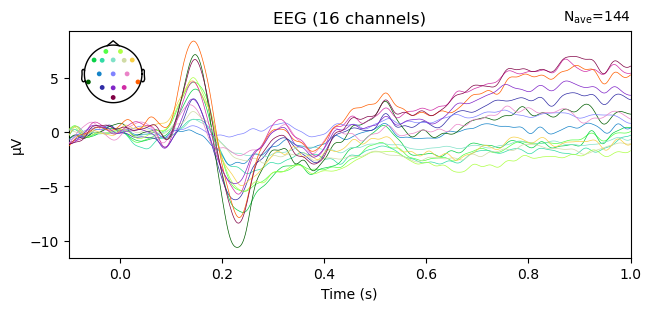

In [28]:
# followed the textbook again
epochs["Match", "Mismatch"].average().plot();

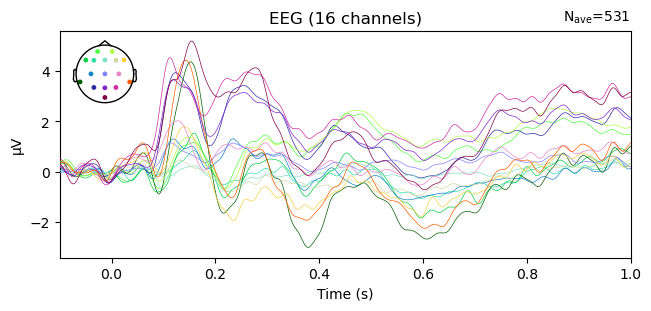

In [29]:
epochs.average().plot(spatial_colors=True);

The above plot shows strong evidence of ocular artifacts in the data: the amplitude scale is on the order of 100 µV, whereas real EEG is rarely more than 10–20 µV, and the largest amplitude values are in channels around the eyes (you can tell this by matching the colours of the lines in the plot with those of the channel locations on the inset showing the electrode layout).

### Scalp topography maps

As we did with ICA components, we can plot the EEG potentials over the scalp using the `.plot_topomap()` method. This will confirm that the artifacts are focused over the electrodes close to the eyes.

~~~python
# Specify times to plot at, as [min],[max],[stepsize]
times = np.arange(0, tmax, 0.1)

epochs.average().plot_topomap(times=times, average=0.050);
~~~

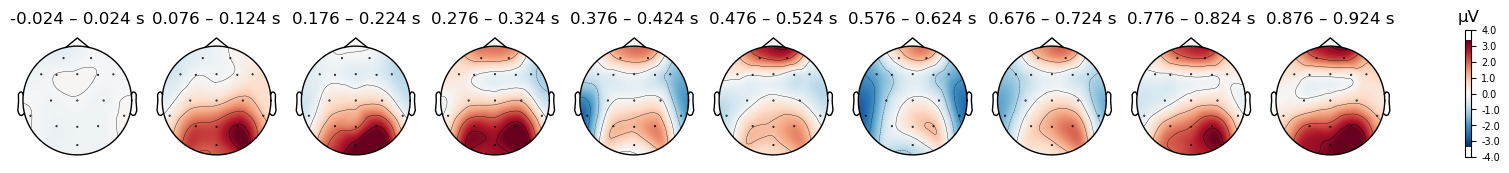

In [30]:
times = np.arange(0, tmax, 0.1)

epochs.average().plot_topomap(times=times, average=0.050);

### Apply ICA correction to epochs

To recap, we have created two different `Epochs` objects: 
- `epochs_ica`, with 1 s segments of the entire raw file, which we fit ICA on to identify artifacts
- `epochs`, with segments time-locked to each event code of experimental interest

Although we fit ICA to the `epochs_ica` data, we can actually *apply* this set of independent components to the `epochs` data. This is because ICA was fitted to the entire raw data set, and `epochs` is just a subset of that original raw data — so the effects of any ICs we marked for exclusion above will be removed from `epochs` with the `ica.apply` method. 

As with many MNE methods (such as filtering, as we saw earlier), the `ICA` `.apply()` method operates on data in-place, meaning it alters the data that is passed to it. In general, my preference is to make copies of data when applying transformations to the data, so here we chain the `.copy()` method.

~~~python
ica = mne.preprocessing.read_ica(data_dir + '/' + p_id + '-ica.fif')

epochs_postica = ica.apply(epochs.copy())
~~~

In [31]:
ica = mne.preprocessing.read_ica(data_dir + p_id + "-ica.fif")

epochs_postica = ica.apply(epochs.copy())

### Visualize average ERP across all conditions after artifact correction

We create the same butterfly plot that we did above, prior to artifact removal, so that we can see if and how the data were cleaned up. Compared to the previous plot, we can see that artifacts have been successfully removed, and the data look more like typical ERP data:
- the large-amplitude deflections, largest at frontal channels, are no longer present
- the amplitude scale (*y* axis) is in the range typical of ERPs
- a series of early peaks typical of responses to visual stimuli are present (a first, small, peak around 75 ms, followed by a larger positive peak around 150 ms and a negative peak around 225 ms)

~~~python
epochs_postica.average().plot(spatial_colors=True);
~~~

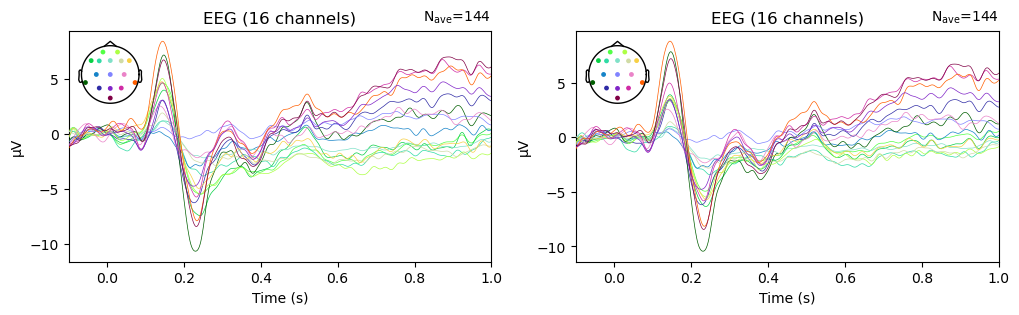

In [35]:
fig, ax = plt.subplots(1, 2, figsize=[12, 3])

epochs["Match", "Mismatch"].average().plot(axes=ax[0], ylim=[-11, 10], show=False);
epochs_postica["Match", "Mismatch"].average().plot(axes=ax[1], ylim=[-11, 10]);

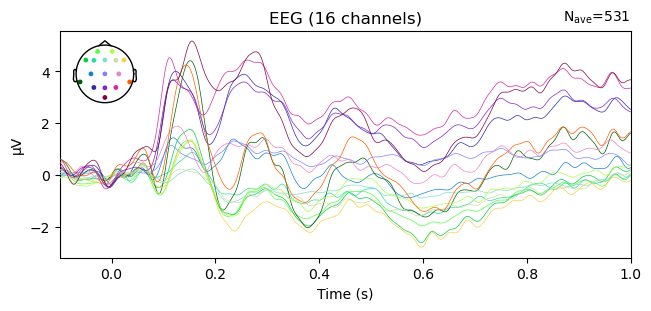

In [32]:
epochs_postica.average().plot(spatial_colors=True);

### Scalp topography maps

We saw this plot above, but now the scalp distribution of the electrical potentials shouldn't be concentrated over the eyes. 

We can also provide a bit more information about how these plots are drawn. We plot topo maps at 100 ms steps from the onset of the code up to the end of the epoch. The `average` kwarg specifies that each plot will reflect the average over a 50 ms time window, centered on each time point for which a plot is drawn. In other words, the plot labeled `0.100 s` reflects the average between 50–150 ms. 

~~~python
# Specify times to plot at, as [min],[max],[stepsize]
times = np.arange(0, tmax, 0.1)

epochs_postica.average().plot_topomap(times=times, average=0.050);
~~~

In [37]:
from autoreject import AutoReject

ar = AutoReject(n_interpolate=[1, 2, 4],
                random_state=42,
                picks=mne.pick_types(epochs_postica.info, 
                                     eeg=True,
                                     eog=False
                                    ),
                n_jobs=-1, 
                verbose=False
                )

epochs_clean, reject_log_clean = ar.fit_transform(epochs_postica, return_log=True)

epochs_clean

Number of events,519
Events,CorResp: 138IncorResp: 0Match/A: 18Match/B: 18Match/C: 18Match/D: 18Mismatch/A: 18Mismatch/B: 18Mismatch/C: 17Mismatch/D: 18PicOnset: 142RespFeedback: 1RespPrompt: 95unused: 0
Time range,-0.100 – 1.000 s
Baseline,-0.100 – 0.000 s


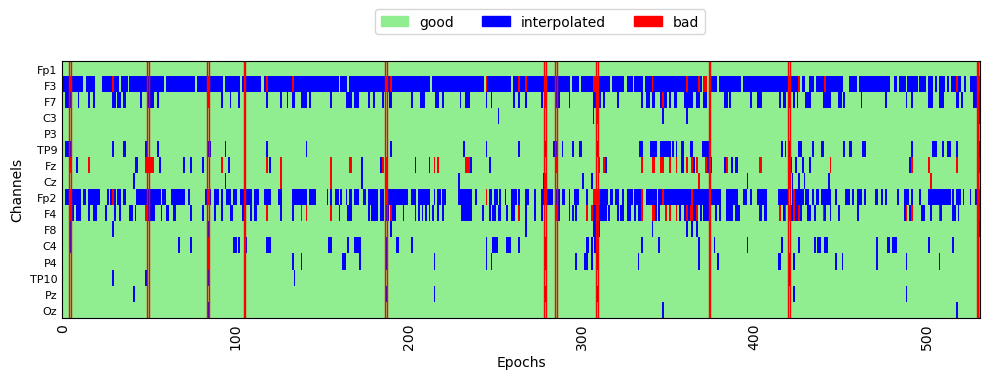

In [38]:
fig, ax = plt.subplots(figsize=[10, 4])
reject_log_clean.plot('horizontal', aspect='auto', ax=ax)
plt.show()


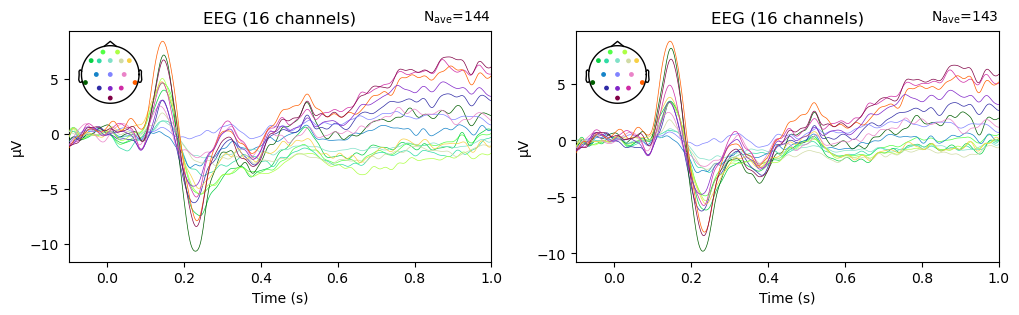

In [39]:
fig, ax = plt.subplots(1, 2, figsize=[12, 3])

epochs['Match', 'Mismatch'].average().plot(axes=ax[0], show=False); # remember the semicolon prevents a duplicated plot
epochs_clean['Match', 'Mismatch'].average().plot(axes=ax[1]);

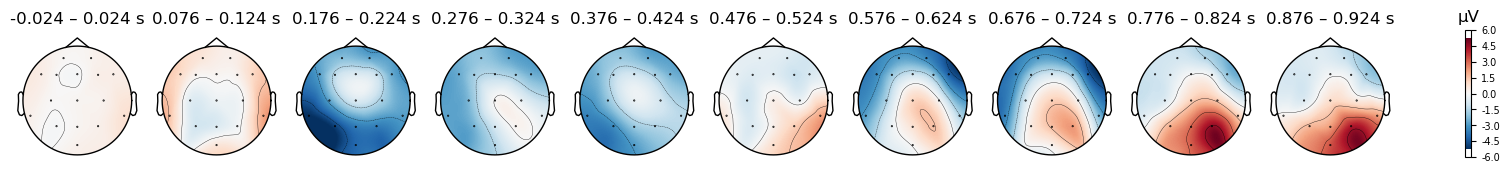

In [40]:
times = np.arange(0, tmax, 0.1)

epochs_clean['Match'].average().plot_topomap(times=times, average=0.050);

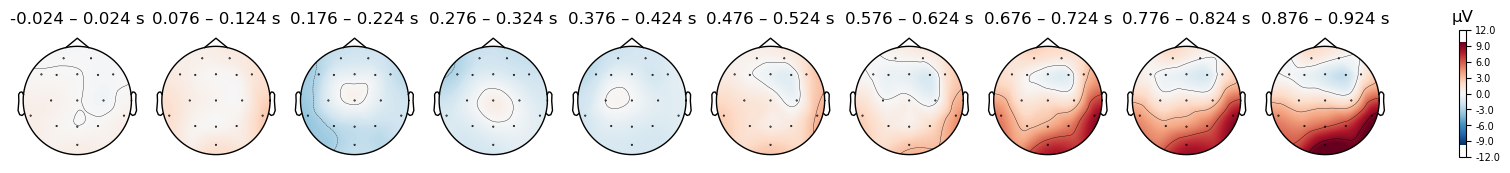

In [41]:
epochs_clean['Mismatch'].average().plot_topomap(times=times, average=0.050);


Match


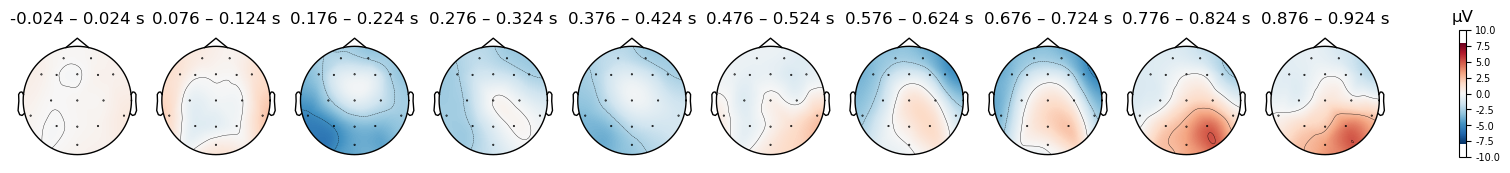

Mismatch


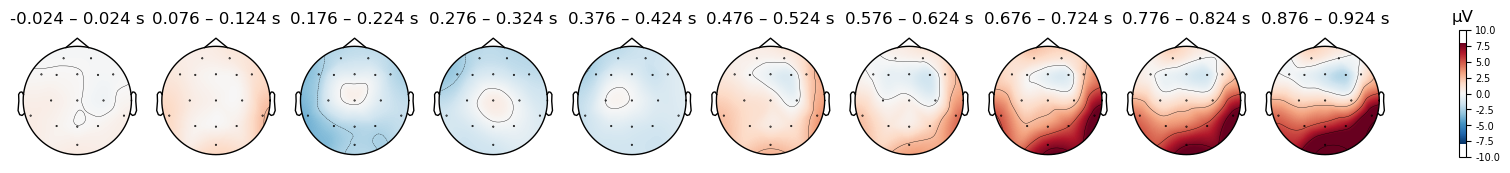

In [42]:
times = np.arange(0, tmax, 0.1)

print('Match')
epochs_clean['Match'].average().plot_topomap(times=times, average=0.050, vlim=(-8, 8));

print('Mismatch')
epochs_clean['Mismatch'].average().plot_topomap(times=times, average=0.050, vlim=(-8, 8));

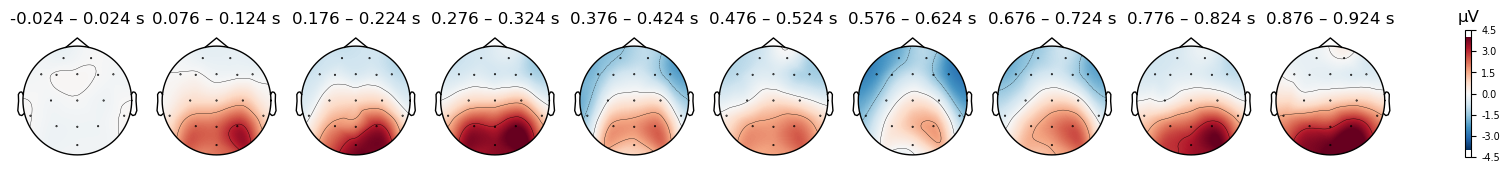

In [36]:
times = np.arange(0, tmax, 0.1)

epochs_postica.average().plot_topomap(times=times, average=0.050);

## Save epochs

~~~python
epochs_postica.save(data_dir + '/' + p_id + '-epo.fif', overwrite=True)
~~~

In [43]:
epochs_clean.save(data_dir + p_id + '-epo.fif', overwrite=True)
